IA & Data science (LU3IN0226) -- 2024-2025
--------
*&copy; Equipe pédagogique: Christophe Marsala, Olivier Schwander, Jean-Noël Vittaut.*


# Mini-projet final

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

- Ekaterina BOGUSH
- Amélie CHU

Ce projet peut être fait en binôme (et c'est fortement conseillé) ou tout seul.

Le nom de chaque membre du binôme doit être indiqué, et <u>**un seul rendu sur un des deux comptes Moodle doit être fait**</u>.

Les groupes de plus de 2 personnes ne sont pas autorisés.

**La dernière séance de TD-TME11 de votre groupe sera réservée pour travailler sur ce mini-projet.**

<font color="RED" size="+1"><b>[Q]</b></font> **Renommer ce fichier ipython**

**Nom à donner au fichier à poster** : *projet-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: il faut rendre le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers vous les rendez séparément.

**Le compte-rendu est soumis sur la page Moodle.**

# Projet 2 - avril-mai 2025


<font size="+1" color="RED"><b>Date de rendu : au plus tard le lundi 19 mai 2025, avant 11h</b></font>
    
<b>Attention! le site Moodle ferme à 11h pile !</b> prévoyez de vous y connecter au moins 15mn avant la fermeture...
<b>Il n'y aura pas de prolongation possible.</b>

Vous devez compléter ce notebook en rajoutant vos expérimentations avec vos algorithmes d'apprentissage sur les données fournies dans le répertoire `data`.



## Travail à faire

Appliquer les algorithmes d'apprentissage vus en cours sur les données comme décrit ci-dessous afin de mettre en évidence des résultats intéressants.


## Compte-rendu demandé
Ce qui doit être remis avant la date limite : un fichier archive (`.tar`, `.tgz`, ou `.zip` uniquement) contenant:
- ce **notebook** complété. Il doit pouvoir être exécuté sans autre apport (pensez à vous en assurer avant de le rendre). 
- votre **librairie iads** sous la forme d'une archive avec votre répertoire `iads/` contenant tous les fichiers nécessaires 
- un **poster** sous la forme d'un fichier PDF dont le nom est de la forme: *tme11-Nom1_Nom2.pdf* qui correspond à un poster décrivant l'ensemble des expérimentations menées et les résultats obtenus.


<b>IMPORTANT</b>: 
- Les <u>fichiers de données ne doivent pas être inclus dans votre archive</u> ! 
- Pensez à vérifier que votre archive contient bien tous les fichiers demandés et **seulement** les fichiers demandés.
- **Tous les fichiers demandés doivent être soumis avant la date limite*, le jour de la soutenance, vous pourrez fournir des versions (légèrement) modifiées.

## Soutenance des projets
La soutenance aura lieu le <font size="+1" color="RED">**mardi 20 mai 2025**</font>, à partir de 9h. Un ordre de passage ainsi que la salle de TME où aura lieu les soutenances seront affichées sur le Moodle la veille (la remise d'un compte-rendu avant lundi 19 mai 11h est obligatoire pour être autorisé à passer une soutenance).

La <b>soutenance est obligatoire</b> : tout projet pour lequel une soutenance n'a pas eu lieu sera noté $0$.

Modalités de la soutenance:
- durée de la soutenance : 10 mn pour un binôme, 7 mn pour un monôme ;
- elle a lieu devant un ordinateur avec le notebook et le poster comme support ;
    - elle commence par une rapide présentation des expérimentations réalisées et résultats obtenus (max. 4 à 5mns)
    - puis elle se poursuit par des questions posées individuellement aux membres du binômes sur les expériences ou le code python réalisé.
- la note de soutenance est individuelle pour chaque membre d'un binôme.


**Très important** : les fichiers de données doivent être placés de façon à respecter la structure de fichiers suivante :

          --iads/
              -- Classifiers.py
              -- etc.
          -- MiniProjet/
              -- ce_notebook.ipynb

Les données seront chargées par les commandes de chargement des données fournies dans ce notebook (ci-dessous).

Dans le notebook que vous rendrez, le chargement des fichiers de données doit considérer cette arborescence.



In [1]:
# Importation de librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
from unidecode import unidecode 
%matplotlib inline  

# un nouvel import utile pour la 3D:
from matplotlib import cm

# Les instructions suivantes sont TRES utiles pour recharger automatiquement 
# le code modifié dans les librairies externes
%load_ext autoreload
%autoreload 2

# Pour mesurer le temps
import time

# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire père du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as classif

# importation de utils
from iads import utils as ut

# importation de evaluation
from iads import evaluation as ev

# importation de Clustering
from iads import Clustering as clust

# Vectorisation des docs avec BoW (binaire ou non), TfIdf
from iads.vectorization import get_bow_vect, get_tfidf_vect

# Prétraitement du text 
from iads.preprocessing import get_corpus, clean_news, lemmatize_filter

sns.set_theme()

# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Données pour le projet : 20newsgroups

Les données sont fournies dans le fichier CSV `20newsgroups.csv` contenu dans l'archive. Une documentation sur ces données peut être consultée sur la <a href="http://qwone.com/~jason/20Newsgroups/" target="NEW">page ScikitLearn</a>.
Ces données sont des dépêches issues de 20 groupes de discussions.


### Chargement des données

In [2]:
newsgroups_df = pd.read_csv("data/20newsgroups.csv")
stop_words_df = pd.read_csv("data/stopwords.csv")
stopwords = stop_words_df["stopword"].values.tolist()

Text(0.5, 1.0, 'Class distribution')

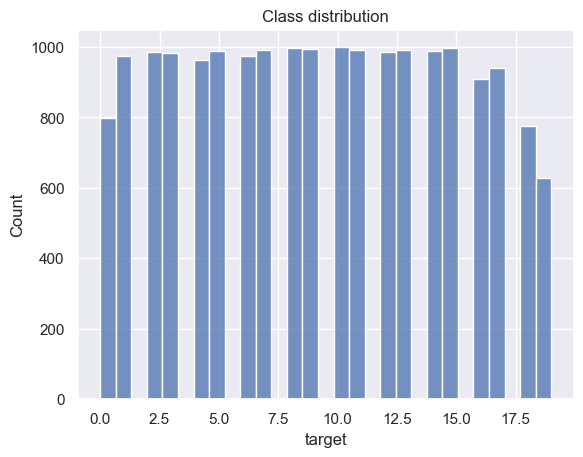

In [3]:
ax = sns.histplot(newsgroups_df["target"])
ax.set_title("Class distribution")

target
0     0.042440
1     0.051459
2     0.051989
3     0.051989
4     0.050928
5     0.052520
6     0.051989
7     0.052520
8     0.053050
9     0.052520
10    0.053050
11    0.052520
12    0.051989
13    0.052520
14    0.052520
15    0.053050
16    0.048276
17    0.049867
18    0.041379
19    0.033422
Name: proportion, dtype: float64

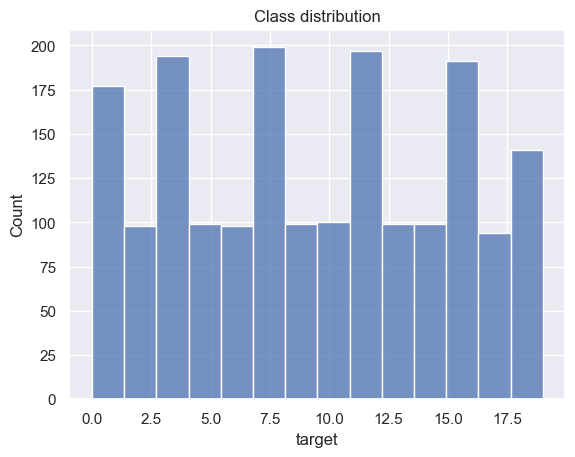

In [4]:
# Sampling with preserving target distribution
np.random.seed(1)
newsgroups_df = newsgroups_df.groupby("target").sample(frac=0.1)
ax = sns.histplot(newsgroups_df["target"])
ax.set_title("Class distribution")

newsgroups_df["target"].unique()
newsgroups_df["target"].value_counts(normalize=True).sort_index()

### Prétraitement

Dans un premier temps, vous devez appliquer les étapes de prétraitements vues dans le TME 6. Pour le nettoyage, la liste des mots inutiles (stopwords) est fournie dans le fichier `stopwords.csv` de l'archive

In [ ]:
newsgroups_df = clean_news(newsgroups_df, stopwords, True, True)
newsgroups_df = lemmatize_filter(newsgroups_df, 3, 10)
corpus = get_corpus(newsgroups_df)
newsgroups_df

Number of Nans 48
Unidecode ok


,Message index,target,messages
0,249,0,law seem value criminal life victim life islam...
1,12210,0,com bill newsgroups alt atheism organization s...
2,4126,0,true believer die belief jesus jim jones well ...
3,8754,0,knowing keith expect bring better oil well dry
4,5782,0,film medium alternative movie source may book ...
...,...,...,...
1810,17918,19,think mistaken thinking tom atheist find athei...
1811,17151,19,would religious belief therefore feel comforta...
1812,12284,19,extremely good example evidence every time rig...
1813,13400,19,vol part vast ocean translation turkish writin...


1. Mettre toutes les lettre en miniscules
2. Enlever punctuation
3. Enlever stopwords ***si nécessaire***
4. Enlever les mots qui ne contient que les chiffres

### Lemmatisation et le tri supplémentaire

# Apprentissage supervisé
**Remarque** : les classifieurs KNN multi-classe, Perceptron sans biais, Naïf Bayes ont été optimisés pour les matrices creuses *(sparse array)* de ***scipy***

### Dataset : **sans** stopwords

##### Naïf Bayes

------ affichage validation croisée
Itération 0: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3915
Itération 1: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3634
Itération 2: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3746
Itération 3: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3352
Itération 4: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3662
------ fin affichage validation croisée
Results [0.39154929577464787, 0.36338028169014086, 0.37464788732394366, 0.3352112676056338, 0.36619718309859156]
Mean accuracy 0.3662, std : 0.0183
Time 1.1341257095336914


Text(0.5, 1.0, 'Confusion matrix')

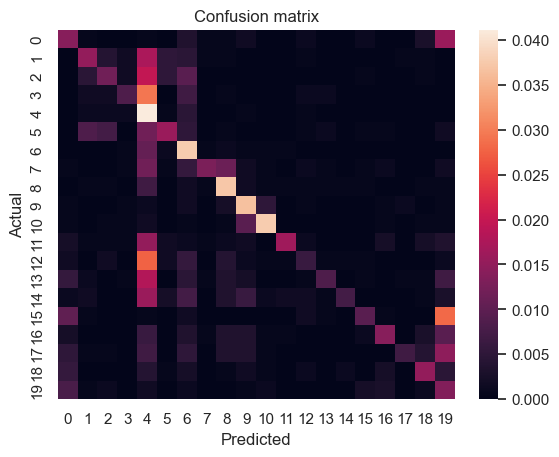

In [22]:
news_labels = news_no_stopwords["target"].values
# !Important! BoW non binaire
news_desc = get_bow_vect(news_no_stopwords, corpus, binary=False)

bayes = classif.NaiveBayes(news_desc.shape[1], corpus, np.unique(news_labels))

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(bayes, (news_desc, news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

#### **Bag-of-words binaire**

In [23]:
news_labels = news_no_stopwords["target"].values
n_classes = news_no_stopwords["target"].nunique()

# BoW binaire
news_desc = get_bow_vect(news_no_stopwords, corpus, binary=True)
news_desc.shape

(1815, 3046)

##### KNN multi-classe [distance **euclidienne**]

Results [0.09295774647887324, 0.10140845070422536, 0.09859154929577464, 0.0676056338028169, 0.07605633802816901]
Mean accuracy 0.0873, std : 0.0132
Time 1.1935839653015137


Text(0.5, 1.0, 'Confusion matrix')

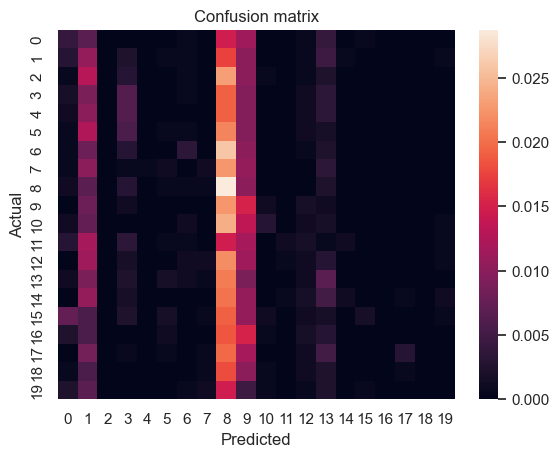

In [24]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=10, C=n_classes, dist_type="euclidean")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### KNN multi-classe [distance **cosinus**]

Results [0.4253521126760563, 0.38028169014084506, 0.38873239436619716, 0.352112676056338, 0.39436619718309857]
Mean accuracy 0.3882, std : 0.0236
Time 1.4668402671813965


Text(0.5, 1.0, 'Confusion matrix')

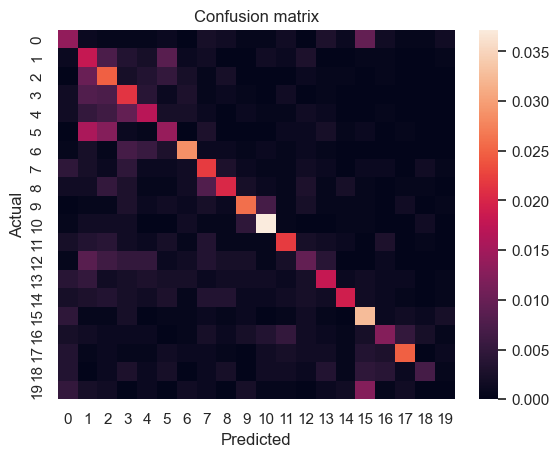

In [25]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=10, C=n_classes, dist_type="cosine")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Perceptron

------ affichage validation croisée
Itération 0: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4930
Itération 1: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4394
Itération 2: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4986
Itération 3: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4563
Itération 4: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4873
------ fin affichage validation croisée
Results [0.49295774647887325, 0.4394366197183099, 0.49859154929577465, 0.4563380281690141, 0.48732394366197185]
Mean accuracy 0.4749, std : 0.0230
Time 74.70056796073914


Text(0.5, 1.0, 'Confusion matrix')

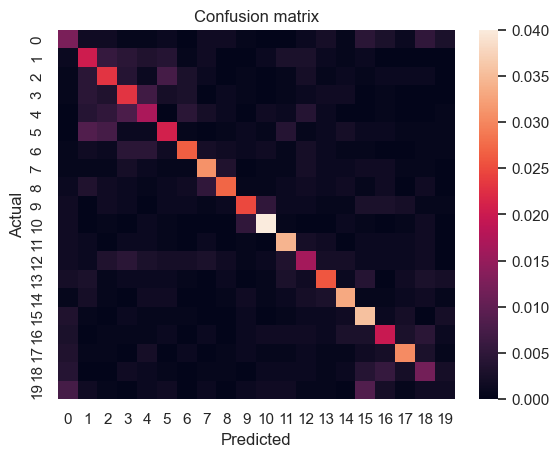

In [26]:
np.random.seed(1)
classifier_perc = classif.ClassifierPerceptron(news_desc.shape[1], 0.01, init=False)
perc_mcc = classif.ClassifierMultiOAA(classifier_perc, classes = np.unique(news_labels))

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(perc_mcc, (news_desc, news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Arbre de décision

------ affichage validation croisée
Itération 0: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3127
Itération 1: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3014
Itération 2: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.2873
Itération 3: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.2817
Itération 4: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.2789
------ fin affichage validation croisée
Results [0.3126760563380282, 0.30140845070422534, 0.28732394366197184, 0.28169014084507044, 0.27887323943661974]
Mean accuracy 0.2924, std : 0.0128
Time 393.5275342464447


Text(0.5, 1.0, 'Confusion matrix')

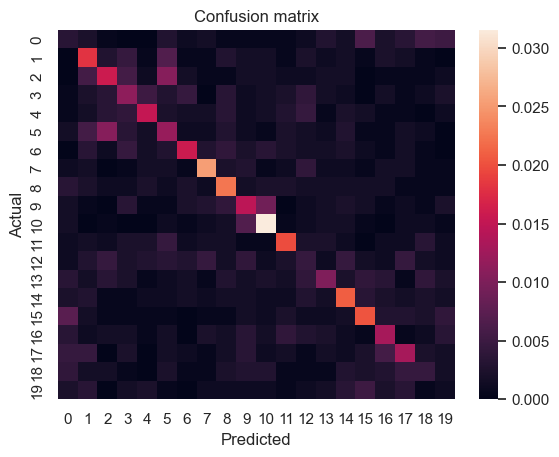

In [27]:
np.random.seed(1)
tree_decision = classif.ClassifierArbreDecision(news_desc.shape[1], epsilon=0.0)

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(tree_decision, (news_desc.toarray(), news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

#### **Bag-of-words avec fréquence**

In [28]:
news_labels = news_no_stopwords["target"].values
n_classes = news_no_stopwords["target"].nunique()

# BoW binaire
news_desc = get_bow_vect(news_no_stopwords, corpus, binary=False)
news_desc.shape

(1815, 3046)

##### KNN multi-classe [distance **euclidienne**]

Results [0.18028169014084508, 0.16056338028169015, 0.17183098591549295, 0.16056338028169015, 0.15211267605633802]
Mean accuracy 0.1651, std : 0.0099
Time 1.5056650638580322


Text(0.5, 1.0, 'Confusion matrix')

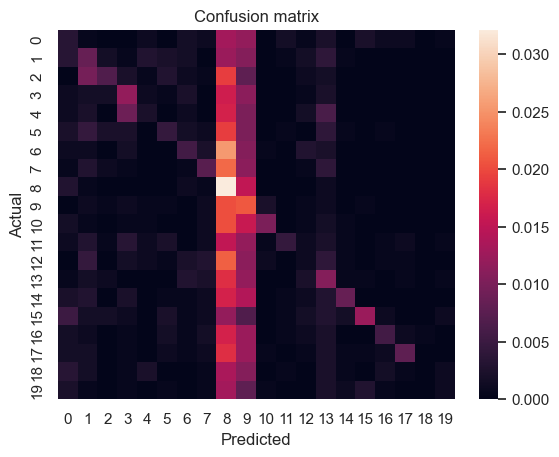

In [29]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=10, C=n_classes, dist_type="euclidean")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### KNN multi-classe [distance **cosinus**]

Results [0.43661971830985913, 0.4140845070422535, 0.4225352112676056, 0.43380281690140843, 0.4619718309859155]
Mean accuracy 0.4338, std : 0.0162
Time 1.7661798000335693


Text(0.5, 1.0, 'Confusion matrix')

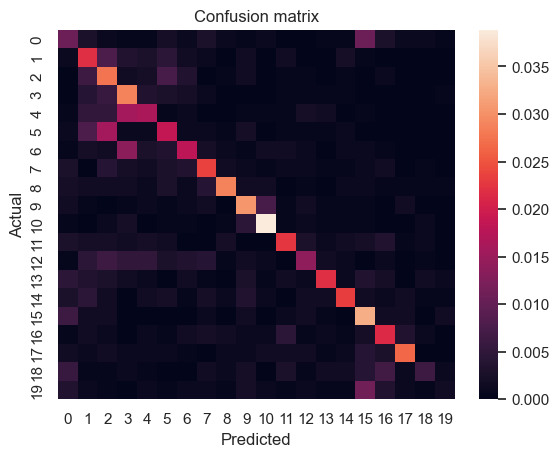

In [30]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=10, C=n_classes, dist_type="cosine")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Perceptron

In [31]:
np.random.seed(1)
classifier_perc = classif.ClassifierPerceptron(news_desc.shape[1], 0.01, init=False)
perc_mcc = classif.ClassifierMultiOAA(classifier_perc, classes = np.unique(news_labels))

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(perc_mcc, (news_desc, news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

------ affichage validation croisée
Itération 0: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4789
Itération 1: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4479


KeyboardInterrupt: 

##### Arbre numérique

------ affichage validation croisée
Itération 0: taille de base app.=1478	taille base test=359	Taux de bonne classif: 0.2758
Itération 1: taille de base app.=1478	taille base test=359	Taux de bonne classif: 0.2981
Itération 2: taille de base app.=1478	taille base test=359	Taux de bonne classif: 0.2618
Itération 3: taille de base app.=1478	taille base test=359	Taux de bonne classif: 0.2618
Itération 4: taille de base app.=1478	taille base test=359	Taux de bonne classif: 0.2786
------ fin affichage validation croisée
Results [0.2757660167130919, 0.298050139275766, 0.2618384401114206, 0.2618384401114206, 0.2785515320334262]
Mean accuracy 0.2752, std : 0.0133
Time 1140.2407879829407


Text(0.5, 1.0, 'Confusion matrix')

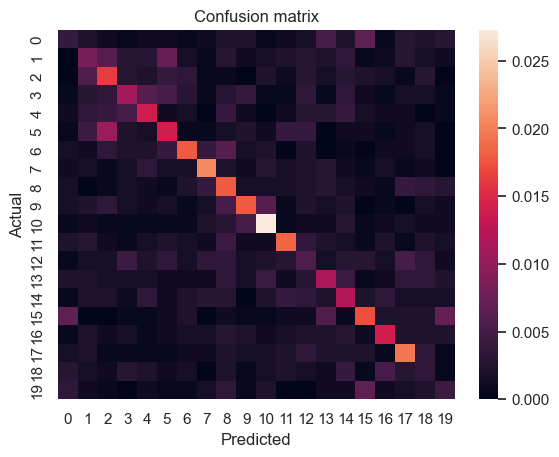

In [ ]:
np.random.seed(1)
tree_numerical = classif.ClassifierArbreNumerique(news_desc.shape[1], epsilon=0.0)

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(tree_numerical, (news_desc.toarray(), news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

### **Vectorisation avec TF-IDF**

In [80]:
news_labels = news_no_stopwords["target"].values
n_classes = news_no_stopwords["target"].nunique()

# BoW binaire
news_desc = get_tfidf_vect(news_no_stopwords, corpus)
news_desc.shape

(1820, 2804)

##### KNN multi-classe [distance **euclidienne**]

Results [0.20612813370473537, 0.1615598885793872, 0.16434540389972144, 0.1671309192200557, 0.20334261838440112]
Mean accuracy 0.1805, std : 0.0199
Time 0.9724438190460205


Text(0.5, 1.0, 'Confusion matrix')

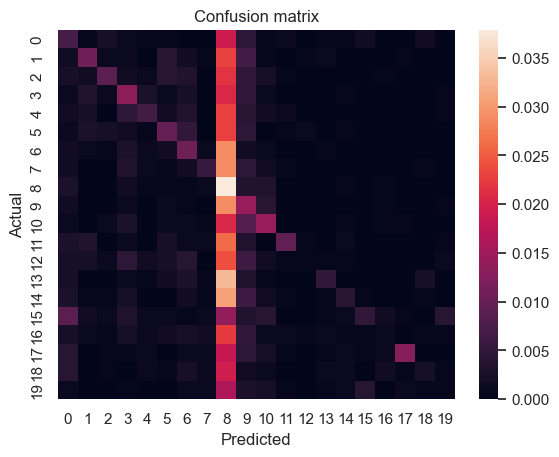

In [164]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=10, C=n_classes, dist_type="euclidean")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### KNN multi-classe [distance **cosinus**]

Results [0.415041782729805, 0.415041782729805, 0.43175487465181056, 0.42896935933147634, 0.4401114206128134]
Mean accuracy 0.4262, std : 0.0098
Time 1.2252411842346191


Text(0.5, 1.0, 'Confusion matrix')

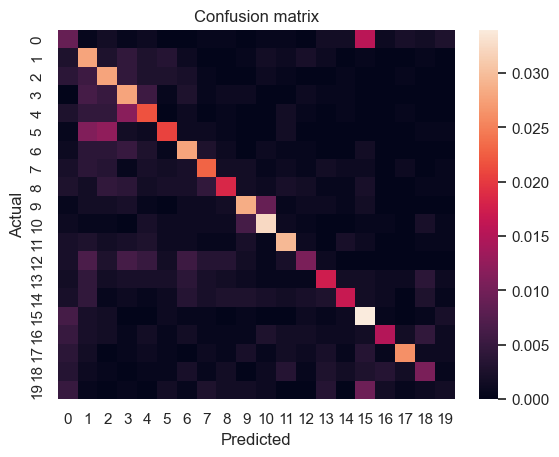

In [165]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=10, C=n_classes, dist_type="cosine")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Perceptron

Results [0.43454038997214484, 0.4011142061281337, 0.40947075208913647, 0.41225626740947074, 0.4428969359331476]
Mean accuracy 0.4201, std : 0.0159
Time 44.31622815132141


Text(0.5, 1.0, 'Confusion matrix')

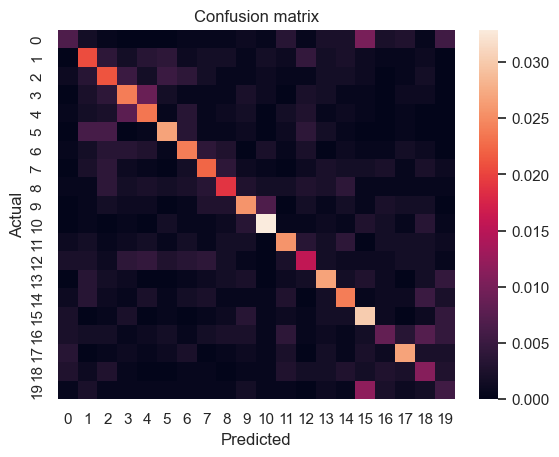

In [ ]:
np.random.seed(1)
classifier_perc = classif.ClassifierPerceptron(news_desc.shape[1], 0.01, init=False)
perc_mcc = classif.ClassifierMultiOAA(classifier_perc, classes = np.unique(news_labels))

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(perc_mcc, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Arbre numérique
Trop long (1 itération 80% train, 20% test ~20 min)

In [167]:
np.random.seed(1)
tree_numerical = classif.ClassifierArbreNumerique(news_desc.shape[1], epsilon=0.0)

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(tree_numerical, (news_desc.toarray(), news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

------ affichage validation croisée
Itération 0: taille de base app.=1478	taille base test=359	Taux de bonne classif: 0.2758


KeyboardInterrupt: 

## Tâches à réaliser

### Apprentissage supervisé

*Tâches*: évaluation d'algorithmes et de représentations des données.
- classification binaire
- classification multi-classe

*Etudes suggérées*:
- représentations des données
    - avec ou sans suppression des stopwords
    - différentes représentations: bag-of-words binaire, avec comptage, avec fréquences, avec tfidf
- différents classifiers:
    - perceptron,
    - k-plus proches voisins avec distance euclidienne,
    - k-plus proches voisins avec distance cosinus (cf. TD),
    - Naives Bayes,
    - arbres de décision
- analyse des résultats:
    - accuracy, temps d'exécutions
    - score fold par fold
    - matrice de confusion


### Apprentissage non-supervisé

*Tâche*: vérifier que le découpage a du sens par rapport aux groupes fournis. 

*Etudes suggérées*:
- étudier l'application d'un clustering hiérarchique et son résultat;
- étudier les résultats de l'application de l'algorithme des k-moyennes, pour différentes valeurs de k;
- proposer des évaluations des clusters trouvés afin de mettre en évidence les plus intéressants:
    - en utilisant les indices d'évaluation présentés en cours;
    - en comparant par diverses méthodes les clusters trouvés avec les vrais labels des classes (targets y).
- proposer une visualisation des résultats obtenus


   


## Poster à rendre dans le compte-rendu (format PDF)

Votre poster doit décrire de façon synthétique **l'ensemble des expérimentations** menées sur les données, les résultats obtenus en apprentissage supervisé et en apprentissage non-supervisé ainsi que les conclusions/bilans que vous tirez de ces expérimentations (ie. ce que vous avez appris sur ces données).

*Remarque*: vous devez indiquer vos noms/prénoms et groupe (1, 2, ou 3) sur le poster.
